## Variable Conventions
<code>
df_final = final dataframe
df = original dataframe
df_five = 5 variables # Use as default unless Peter's analysis suggest otherwise
df_seven = 7 variables
<code>

# Lab 2: Network Intrusion Detection

In [15]:
# Imports
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np


%matplotlib inline

In [8]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')

# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"      

df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] 

df_five.info()
df_five.describe()


duplicate record deleted successfully: 82328 observations remaining
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 6 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
label               82328 non-null int64
dtypes: int64(6)
memory usage: 4.4 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,1.000000


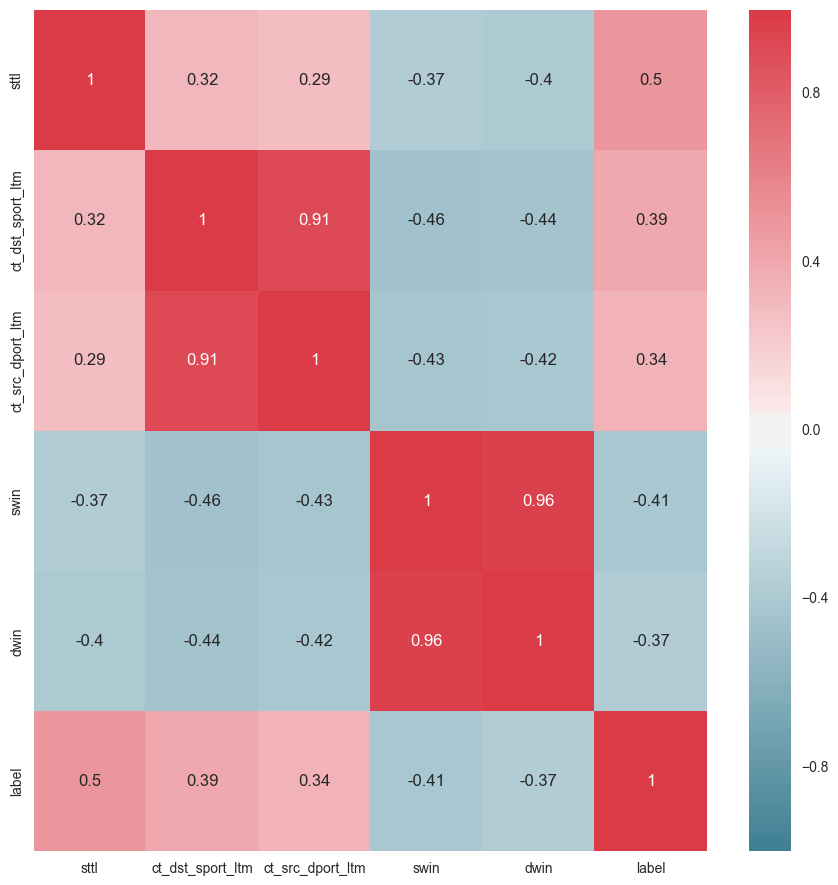

In [9]:
# plot the correlation matrix using seaborn
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_five.corr(), cmap=cmap, annot=True)

f.tight_layout()

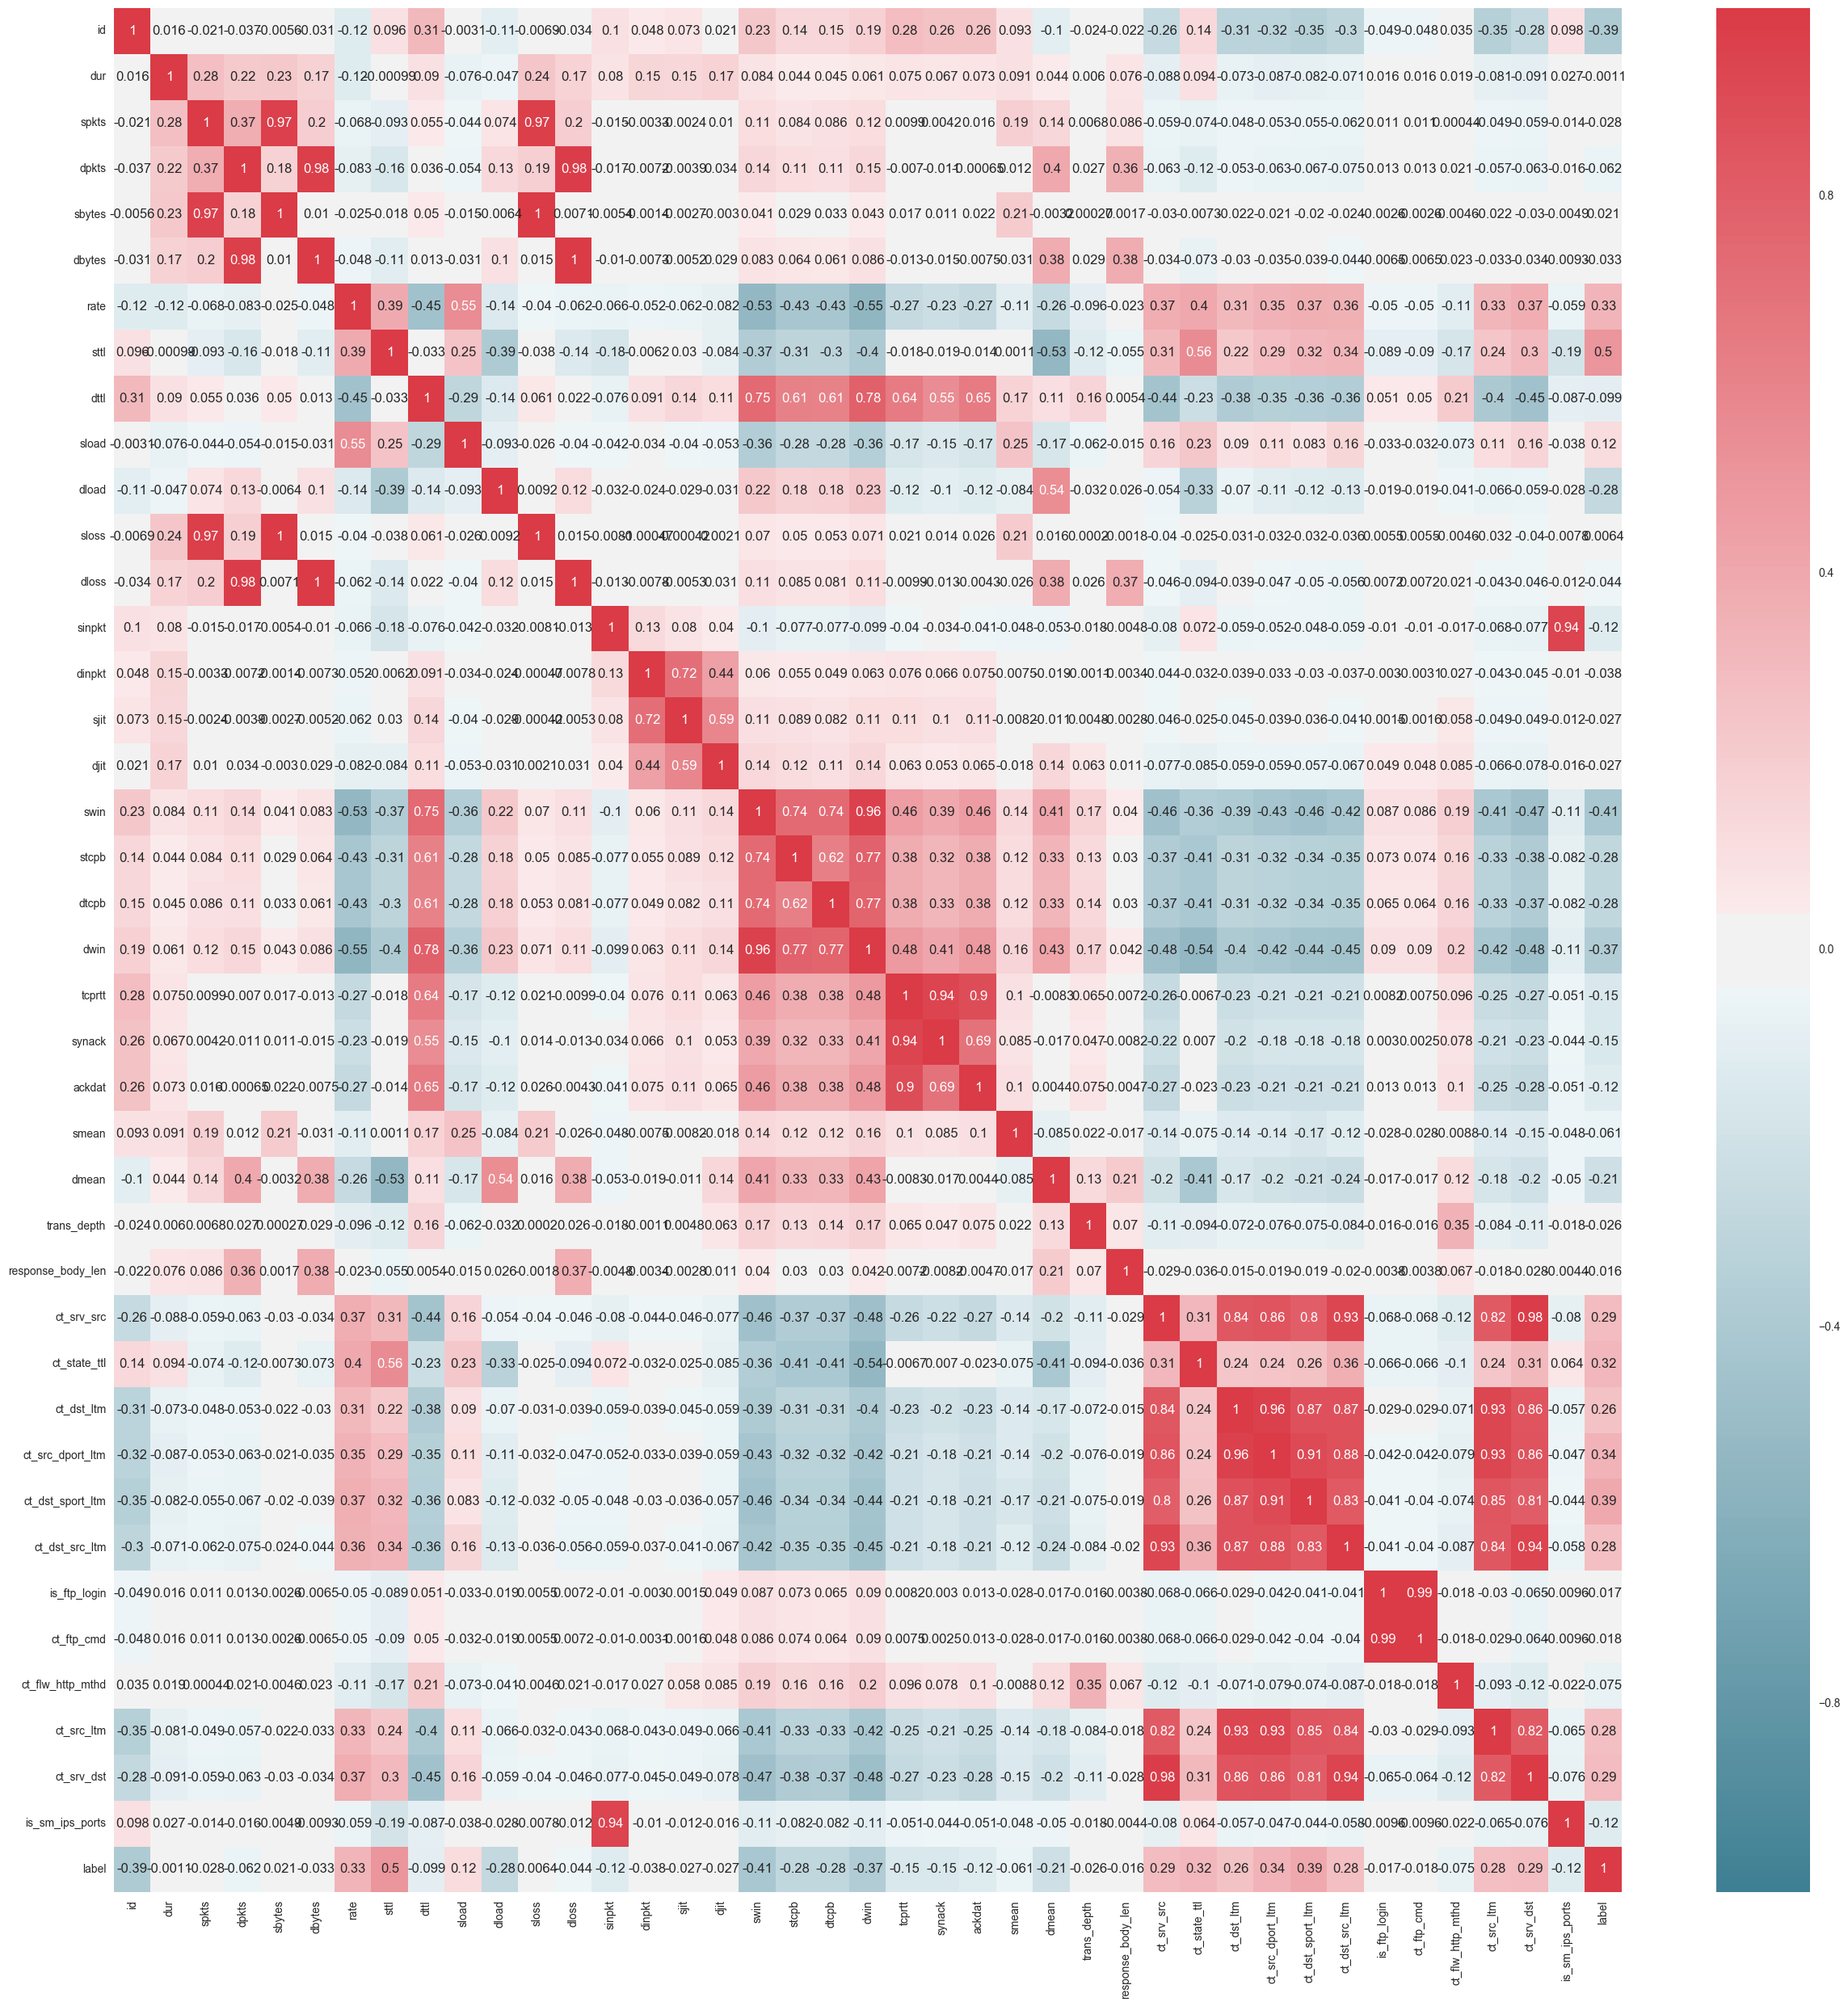

In [7]:
f, ax = plt.subplots(figsize=(25, 25))

sns.heatmap(df.corr(), cmap=cmap, annot=True)

f.tight_layout()

### df_five: Why is it significant?
* We chose df_five as our base model because those are the five features that are the most correlated to our response variable (label). 
    * As shown in the heatmaps above, we can see that these five features have the most apparent influence over *label*
        * In the heatmaps, we are focusing our attention on the bottom row (label) as it correlates to the rest of the features. 
        * We see that the five most correlated features are:
            * 'sttl',
            * 'ct_dst_sport_ltm', 
            * 'ct_src_dport_ltm', 
            * 'swin', 
            * 'dwin'

# SHOULD WE JUST CUT OUT THE df_seven SECTION
# OR LEAVE IT IN TO SHOW WE DID OUR DUE DILIGENCE

In [19]:
# based on feedback from mini lab, we want to check if accuracy increases from the selected 5 features to include the following
# two additional features: 'dttl', 'ct_dst_src_ltm',
df_seven = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'dttl', 'ct_dst_src_ltm', 'label' ]] # 
df_seven.info()
df_seven.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 8 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
dttl                82328 non-null int64
ct_dst_src_ltm      82328 non-null int64
label               82328 non-null int64
dtypes: int64(8)
memory usage: 5.7 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,dttl,ct_dst_src_ltm,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.00000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,95.70541,7.456528,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,116.66547,11.415443,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,29.00000,3.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,252.00000,6.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,253.00000,63.000000,1.000000


## Data Preparation:

* Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [11]:
# One-hot encode our object features:

# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)  # Note

Based on this one-hot encoding, the above categorical variables cause the features to increase based on sum of unique values. so $$43 + 131 + 13 + 7 - 3 = 191$$
Must subtract $3$ for the 3 original columns that exist

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB


In [ ]:
# Peter
# df_five and df_seven based of describe does not require one-hot encoding and is ready for modeling
# First lets redo accuracy results for logistic regression on original 5 features selected based on correlation matrix from
# from lab 1 for accuracy comparision with additional 2 features suggested by grader using logistic regression model
# with 80/20 shuffle split cross validation to determine if we should proceed with original 5 or add additional two features for
# 


In [16]:
# we want to predict the X and y data as follows for 5 feature iteration: 
if 'label' in df_five:
    y = df_five['label'].values # get the labels we want
    del df_five['label'] # get rid of the class label
    X = df_five.values # use everything else to predict!

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print cv_object

ShuffleSplit(82328, n_iter=3, test_size=0.2, random_state=None)


In [17]:
# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
for train_indices, test_indices in cv_object:
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)

accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)
print "Average Accuracy (5 feature set) across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(np.average(accuracies))

[ 0.76442366  0.76952508  0.7652739 ]
Average Accuracy (5 feature set) across 3 shuffle split cross validation iterations = 0.766407546864


In [20]:
# we want to predict the X and y data as follows for 7 feature iteration: 
if 'label' in df_seven:
    y = df_seven['label'].values # get the labels we want
    del df_seven['label'] # get rid of the class label
    X = df_seven.values # use everything else to predict!

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

In [21]:
# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
for train_indices, test_indices in cv_object:
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)

accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)
print "Average Accuracy (7 feature set) across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(np.average(accuracies))

[ 0.77705575  0.77250091  0.77037532]
Average Accuracy (7 feature set) across 3 shuffle split cross validation iterations = 0.773310660351


Based on the results there was negligible increase in accuracy with respect to including the additional 2 features
requested by the grader in terms of explaining the data.  Hence we we stick with the original 5 based on correlation results
from mini lab.

* Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [10]:
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to predict!
dfcopy.info() # should have 190 entries
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

# determine if we have roughly the same percentage of  normal vs abnormal observations
# ref: http://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
# ref: http://www.gossamer-threads.com/lists/python/python/809232 (print percentage)
unique, counts = np.unique(y, return_counts=True)
uniqueClassCounts = dict(zip(unique, counts))    
totalObservations = len(y)
print uniqueClassCounts
print "Percent normal(0) is {0:.0%}".format(float(uniqueClassCounts[0])/totalObservations)
print "Percent attack(1) is {0:.0%}".format(float(uniqueClassCounts[1])/totalObservations)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 43 columns):
dur                  82328 non-null float64
proto                82328 non-null object
service              82328 non-null object
state                82328 non-null object
spkts                82328 non-null int64
dpkts                82328 non-null int64
sbytes               82328 non-null int64
dbytes               82328 non-null int64
rate                 82328 non-null float64
sttl                 82328 non-null int64
dttl                 82328 non-null int64
sload                82328 non-null float64
dload                82328 non-null float64
sloss                82328 non-null int64
dloss                82328 non-null int64
sinpkt               82328 non-null float64
dinpkt               82328 non-null float64
sjit                 82328 non-null float64
djit                 82328 non-null float64
swin                 82328 non-null int64
stcpb                82328 non-n

## Modeling and Evaluation:
* Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.


http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

Once you have a model that you believe can make robust predictions you need to decide whether it is a good enough model to solve your problem. Classification accuracy alone is typically not enough information to make this decision.

Classification accuracy is our starting point. It is the number of correct predictions made divided by the total number of predictions made, multiplied by 100 to turn it into a percentage.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).

P = T_p / (T_p+F_p)

Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).

R = (T_p) / (T_p + F_n)

These quantities are also related to the (F_1) score, which is defined as the harmonic mean of precision and recall.

F1 = 2 ( (P*R) / (P+R) )


http://hackercollider.com/articles/2016/06/03/recall-vs-precision/



With our particular dataset there are a couple of different view points on which performance metrics a model should be tuned for for this particular dataset:
1) False negatives are probably worse than false positives. If a malicious packet gets through undetected, it could potentially do bad things without being noticed, whereas a false positive could be rescreened or reviewed to clear the packet. Note: however, if the system has protection in depth, perhaps down stream systems may catch the packet or some effect of the malicous abnormal packet (e.g. host based intrusion detection system, so it may not be that bad).
Recall may be a good metric to gauge model performance based on highlighting false negatives. Recall is defined as the number of True Postivies divided by the number of True Positives and the number of False Negatives, also known as Sensitivity or the True Postive Rate. 

2) However, if there are too may false positives, where the system over classifies packets as malcious when they really aren't then it could be interfering with normal operations and impact business operations. On the assumption that it takes some signficant amount of time to clear a tagged (false) positive packet. If a tool identifies too many false positives, people would lose trust with the system. Based on this view, precision which is defined as the number of True Positives divided by the number of True Positives and False positives would be a good metric to use to gauge performance of models used for predicting abnormal packets.

3) Based on these view points, a metric which combines both would be the F1 Score which is 2*((precision*recall)/(precision+recall)) also know as the F Score or F Measure which tries to convey the balance between precision and recall. 

*  Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

ref:
(a) http://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation
(b) http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
(c) http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/


Per ref (a) startification in general seeks to ensure each fold is representative of all strata in the data. The label feature has two classes (categories) as seen above normal(0) and attack(1) with percentages of 45% and 55%, respectively based on distribution of the classes with respect to the complete dataset. If it was 50%/50% one could argue a random sampling should create evenly distributed folds and with large enough sample size, should be sufficient. The main argument for stratification is to address the biasing effects of classification algorithms based on over/under representation of classes in any one particular sample or folds for classification algorithms that do not inherently have inherent balancing techniques either by selection or weighting.  According to ref (a), however, it does lead to a loss of diversity (unwanted loss of variance). Basically, the more unbalanced then the classes are, the more biased a classification algorithm in general would be to the observations tending to the more popular class. Stratification seeks to correct for that artificially to address algorithms that cleverly try and predict the class witht the highest weighting based on class distribution.

Since the values in the labels are not exactly equal, a stratified Kfold validation is recommended so that each set or fold contains approximately the same percentage of samples of each target class as the complete set.
Note: Will do both for comparision sake to see if there is any difference
in results and to get a feel for the methodology.

Note: per ref (a) To combat imbalanced training data, one technique woudl be to try and colect more data with a larger dataset.  However. since we did not generate this data ourselves, this would not be an option.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
#ref : http://stackoverflow.com/questions/2866380/how-can-i-time-a-code-segment-for-testing-performance-with-pythons-timeit
import time
#ref: http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html
numObservations = len(dfcopy)
print numObservations
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

num_folds = 10
kf = KFold(numObservations, n_folds=num_folds)
skf = StratifiedKFold(y, num_folds)

# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
print(kf)
t0 = time.clock()

for train_index, test_index in kf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0

accuracies = cross_val_score(lr_clf, X, y=y, cv=kf) # this also can help with parallelism
#print(accuracies)
print "Average Accuracy across " + str(num_folds) + " fold cross validation iterations = " + str(np.average(accuracies)) + " training time = " + str(total)    

t0 = time.clock()
for train_index, test_index in skf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
# http://scikit-learn.org/stable/modules/model_evaluation.html
accuracies = cross_val_score(lr_clf, X, y=y, cv=skf) # this also can help with parallelism
precision = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='precision')
recall = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='recall')
accuracy = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='accuracy')
f1 = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='f1')# just testing to see if it is same as default
#print(accuracies)
#print "Percent normal(0) is {0:.0%}".format(float(classCounts[0])/totalObservations)
print "Average Accuracies across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%} ".format(np.average(accuracies)) + " training time = " + str(total)    
print "Average Precision across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(precision)) + " training time = " + str(total)    
print "Average Recall(Sensitivity) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(recall)) + " training time = " + str(total)    
print "Average Accuracy across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(accuracy)) + " training time = " + str(total)    
print "Average F measure(F1) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(f1)) + " training time = " + str(total)    

# http://stackoverflow.com/questions/23339523/sklearn-cross-validation-with-multiple-scores
from sklearn import metrics
def mean_scores(X, y, clf, skf):

    cm = np.zeros(len(np.unique(y)) ** 2)
    for i, (train, test) in enumerate(skf):
        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        cm += metrics.confusion_matrix(y[test], y_pred).flatten()

    return compute_measures(*cm / skf.n_folds)

def compute_measures(tp, fp, fn, tn):
     """Computes effectiveness measures given a confusion matrix."""
     specificity = tn / (tn + fp)
     sensitivity = tp / (tp + fn)
     fmeasure = 2 * (specificity * sensitivity) / (specificity + sensitivity)
     return sensitivity, specificity, fmeasure
    
print mean_scores(X, y, lr_clf, skf)

82328
sklearn.cross_validation.KFold(n=82328, n_folds=10, shuffle=False, random_state=None)
Average Accuracy across 10 fold cross validation iterations = 0.717766267375 training time = 8.64873982526
Average Accuracies across stratified 10 fold cross validation iterations = 76%  training time = 9.29193030423
Average Precision across stratified 10 fold cross validation iterations = 79% training time = 9.29193030423
Average Recall(Sensitivity) across stratified 10 fold cross validation iterations = 82% training time = 9.29193030423
Average Accuracy across stratified 10 fold cross validation iterations = 76% training time = 9.29193030423
Average F measure(F1) across stratified 10 fold cross validation iterations = 79% training time = 9.29193030423
(0.75621391674263139, 0.75488688332186649, 0.75554981733859294)


The stratified 10 fold cross validation appears to have a higher accuracy score of 76% vs 71%. Not much difference in computational expense between the two cross validation methods.
    # https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/
   
   Sensitivy/recall measures how good the model is at detecting the positives, which somewhat important.

*  Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! 

In [26]:
# y is declared above
num_folds = 10
cv_object = StratifiedKFold(y, num_folds)

t0 = time.clock()
for train_index, test_index in cv_object:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0

In [ ]:
# Peter, Ravi, Randy, and Daniel

*  Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

In [ ]:
# Team

* Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation. 

In [ ]:
# Team or TBD

* Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

In [ ]:
# Team or TBD

## Deployment:
* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

In [ ]:
# Daniel

## Exceptional Work:

You have free reign to provide additional analyses

• One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?

In [ ]:
# Randy and team